In [72]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, InputLayer, Input
import matplotlib.pyplot as plt

In [85]:
data_dir = 'data/'
with open(data_dir + 'FPT.csv') as f:
    data = pd.read_csv(f)
    data['time'] = pd.to_datetime(data['Date/Time'])

daily_data = data.groupby(data['time'].dt.date).agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
}).reset_index()

daily_data.head(), daily_data.describe()

(         time   Open   High    Low  Close  Volume
 0  2018-12-25  30.89  30.89  30.59  30.66   84960
 1  2018-12-26  31.04  31.22  30.89  30.89  333590
 2  2018-12-27  31.41  31.52  31.19  31.19  454860
 3  2018-12-28  31.34  31.49  31.19  31.49  387170
 4  2019-01-02  31.19  31.45  30.70  30.74  459120,
              Open        High         Low       Close        Volume
 count  499.000000  499.000000  499.000000  499.000000  4.990000e+02
 mean    44.299699   44.756633   43.906994   44.332144  1.570242e+06
 std      6.765702    6.823155    6.689798    6.757144  9.530781e+05
 min     30.290000   30.890000   30.220000   30.440000  8.496000e+04
 25%     38.260000   38.590000   37.900000   38.090000  9.206850e+05
 50%     46.500000   47.000000   46.090000   46.520000  1.339560e+06
 75%     49.000000   49.500000   48.570000   49.080000  2.004005e+06
 max     57.500000   58.500000   57.200000   58.100000  6.853810e+06)

In [86]:
# Assuming 'daily_data' has been aggregated as shown above
features = daily_data[['Open', 'High', 'Low', 'Close', 'Volume']].values

# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Create sequences of consecutive days
def create_daily_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length, 3]  # Index 3 is the 'Close' price
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30  # Days
X, y = create_daily_sequences(scaled_features, seq_length)
X_org, y_org = create_daily_sequences(features, seq_length)


In [87]:
X.shape, y.shape

((469, 30, 5), (469,))

In [93]:
features = data[['Open', 'High', 'Low', 'Close', 'Volume', 'month', 'DayOfWeek']].values
print(features)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
print(scaled_features)

KeyError: "['month', 'dow'] not in index"

In [34]:
# Keep the 'Close' price in original scale for evaluation
close_prices = data['Close'].values.reshape(-1, 1)
scaled_close_prices = scaler.fit_transform(close_prices)
scaled_features[:, 3] = scaled_close_prices.squeeze()
scaled_close_prices

array([[0.02273535],
       [0.01989343],
       [0.01740675],
       ...,
       [0.9928952 ],
       [0.98934281],
       [0.98934281]])

In [50]:
def get_index_range_from_time_span(data, time_span, start_index=0):
    start_time = data['time'][start_index]
    end_time = start_time + pd.Timedelta(time_span)
    _range =  data[(data['time'] >= start_time) & (data['time'] < end_time)].index
    end_index = _range[-1]
    return _range, end_index

get_index_range_from_time_span(data, '60D')

(Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
        ...
        4620, 4621, 4622, 4623, 4624, 4625, 4626, 4627, 4628, 4629],
       dtype='int64', length=4630),
 4629)

In [84]:
# Create sequences of 60 days
def create_sequences(raw_data, features, time_span, start_index=0):
    xs, ys = [], []
    
    def get_index_range_from_time_span(data, time_span, start_index):
        start_time = data['time'][start_index]
        end_time = start_time + pd.Timedelta(time_span)
        _range =  data[(data['time'] >= start_time) & (data['time'] < end_time)].index
        end_index = _range[-1]
        return _range, end_index

    start_index, end_index = 0, 0
    while start_index < len(raw_data):
        _, end_index = get_index_range_from_time_span(raw_data, time_span, start_index)
        seq_length = end_index - start_index
        x = features[start_index:(start_index+seq_length)]
        y = features[start_index+seq_length, 3]  # index 3 is the 'Close' price
        print(x.shape, y.shape)
        xs.append(x)
        ys.append(y)
        # print(seq_length, start_index, start_index+seq_length)
        start_index = end_index + 1
    return np.array(xs, dtype=object), np.array(ys, dtype=object)

X, y = create_sequences(data, scaled_features, '60D')

(4629, 7) ()
(6598, 7) ()
(7009, 7) ()
(8960, 7) ()
(8671, 7) ()
(8340, 7) ()
(7671, 7) ()
(9327, 7) ()
(8658, 7) ()
(9250, 7) ()
(9129, 7) ()
(8936, 7) ()
(215, 7) ()


In [89]:
def create_sequences_2(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length, 3]  # index 3 is the 'Close' price
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 60
_X, _y = create_sequences_2(scaled_features, seq_length)

In [90]:
_X.shape, _y.shape

((97346, 60, 7), (97346,))

In [88]:
model = Sequential([
    Input(shape=(X.shape[1], X.shape[2])),
    LSTM(50, return_sequences=True, activation='linear'),
    Dropout(0.2),
    LSTM(50, return_sequences=False, activation='linear'),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')


In [89]:
# Splitting the dataset into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
Y_org_train, Y_org_test = y_org[:train_size], y_org[train_size:]
# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test))


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2898 - val_loss: 0.0016
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0111 - val_loss: 0.0337
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0099 - val_loss: 0.0024
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0084 - val_loss: 0.0154
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0083 - val_loss: 0.0029
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0061 - val_loss: 0.0036
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0056 - val_loss: 0.0030
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0070 - val_loss: 0.0062
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0053 - val_loss: 0.0012
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0064 - val_loss: 0.0079
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

In [69]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((375, 30, 5), (375,), (94, 30, 5), (94,))

In [90]:
predictions = model.predict(X_test)

# Undo normalization for evaluation
predictions = predictions.reshape(-1, 1)
dummy_array = np.zeros((len(predictions), scaled_features.shape[1]))
dummy_array[:, 3] = predictions.squeeze() 
predictions_rescaled = scaler.inverse_transform(dummy_array)[:, 3]

# Calculate RMSE
rmse = np.sqrt(np.mean((predictions_rescaled - Y_org_test)**2))
print(f'RMSE: {rmse}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
RMSE: 1.4359799489912055


In [95]:
X_test[-1:].shape

(1, 30, 5)

In [103]:
# Generate the next 30 days' predictions
last_sequence = X_test[-1:]  # Starting sequence
new_predictions = []

for _ in range(30):
    # Predict the next day
    next_day_prediction = model.predict(last_sequence)
    
    # Update the sequence with the new prediction
    new_sequence = np.roll(last_sequence, -1, axis=1)
    new_sequence[:, -1, 3] = next_day_prediction  # Update the 'Close' price position
    
    # Save the new prediction
    new_predictions.append(next_day_prediction[0][0])
    
    # Use the updated sequence for the next prediction
    last_sequence = new_sequence

# Rescale predictions back to original scale
new_predictions = np.array(new_predictions).reshape(-1, 1)
dummy_array = np.zeros((len(new_predictions), scaled_features.shape[1]))
dummy_array[:, 3] = new_predictions.squeeze()
forecast_rescaled = scaler.inverse_transform(dummy_array)[:, 3]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

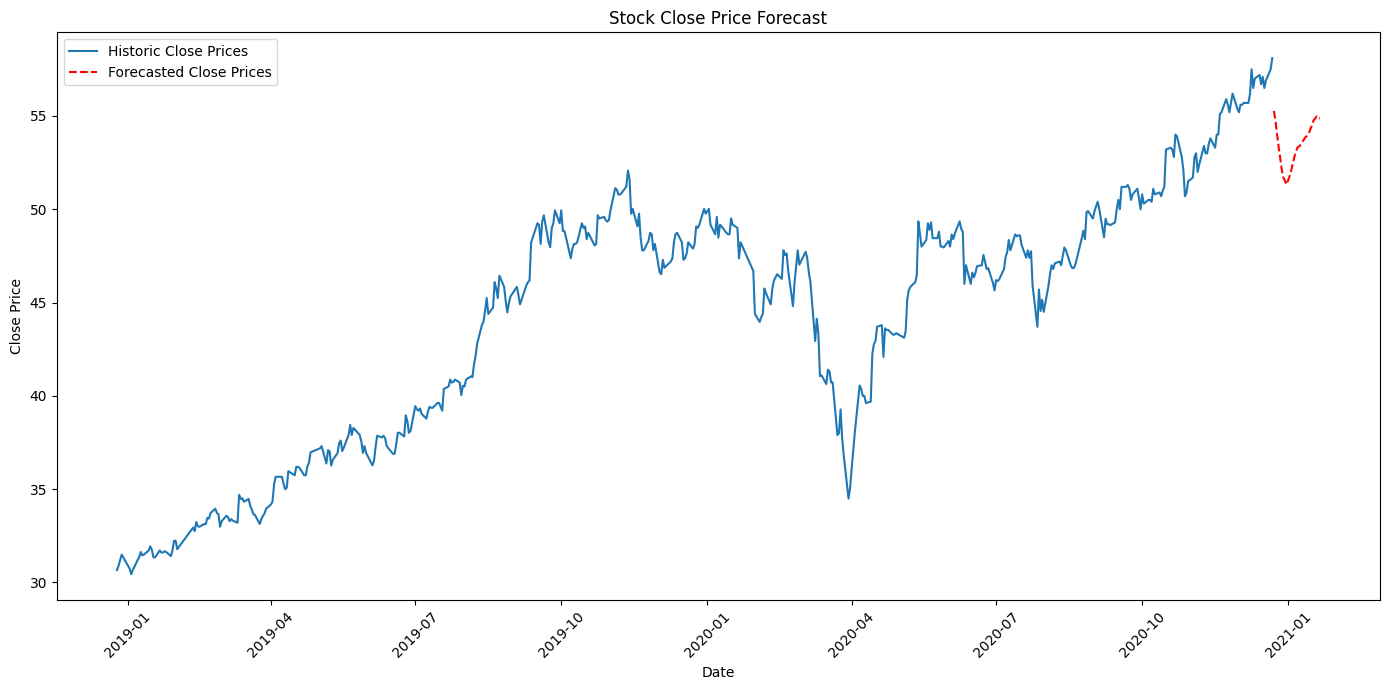

In [104]:
# Dates for the historic data
historic_dates = daily_data['time']

# Generating future dates for the forecast
last_date = daily_data['time'].iloc[-1]
forecast_dates = [last_date + pd.Timedelta(days=i) for i in range(1, 31)]

# Plotting historic data
plt.figure(figsize=(14, 7))
plt.plot(historic_dates, daily_data['Close'], label='Historic Close Prices')

# Plotting forecasted data
plt.plot(forecast_dates, forecast_rescaled, label='Forecasted Close Prices', linestyle='--', color='red')

plt.title('Stock Close Price Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()